In [1]:
import sys
import numpy as np
from netCDF4 import Dataset
import requests
import io
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, cm, maskoceans
from matplotlib.colors import LinearSegmentedColormap

In [2]:
# SETTINGS
STATION = "DE0043G" # GIVE STATION CODE
# NOTE stations DE0043G    DE0044R    ES0019U    ES0020U    FR0020R    IT0004R    IT0013R    RO0007R FR0026R are lidar and for these ALT>0 is allowed [0, 100, 500, 4000]
YEAR = 2023# GIVE YEAR
MON = 7 # GIVE MONTH
ALT = 100 # GIVE ALTITUDE
DD = 20 # GIVE DAY
TT = 12 # GIVE THE TIME IN 3 HOURLY INTERVALS LIKE 0, 3, 6, ..., 21
PROJ = "REGIONAL" # GIVE THE PROJECTION YOU WANT TO SEE: CHOOSE BETWEEN GLOBAL, REGIONAL, POLAR 

##### DO NOT CHANGE BELOW UNLESS YOU KNOW WHAT YOU DO #####
# Available stations and their coordinates
STNLIST = ["NO0042G", "FI0050R", "FR0030R", "CZ0003R", "GR0002R", "CH0002R", "CH0001G", "GR0100B", "ES0018G", "IT0009R", "NO0002R", "ES0100R", "GR0101R","DE0043G", "DE0044R", "ES0019U", "ES0020U", "FR0020R", "IT0004R", "IT0013R", "RO0007R", "FR0026R"]
LONLIST = [11.88668, 24.283333, 2.964886, 15.080278, 25.669399, 6.944722, 7.985, 23.816, -16.4994, 10.7, 8.252, -6.733, 22.196262, 11.009619, 12.9277, 2.116111, -3.605, 2.158889, 8.633333, 15.7237, 26.029, 55.383]
LATLIST = [78.90715, 61.85, 45.772223, 49.573394, 35.337799, 46.813056, 46.5475, 37.994999, 28.309, 44.183333, 58.38853, 37.1, 37.984265, 47.801498, 51.5255, 41.39, 37.164, 48.708611, 45.8, 40.601, 44.348, -21.0794]
ALTLIST = [0, 100, 500, 4000, 6000]


In [3]:
# Find coordinates of the station given in SETTINGS
xx = []; yy = []
for i in range(len(STNLIST)):
    if STNLIST[i] == STATION:
        xx.append(LONLIST[i])
        yy.append(LATLIST[i])

print("The coordinates of",STATION, "are",xx, "and",yy)

The coordinates of DE0043G are [11.009619] and [47.801498]


In [10]:
# Find altitude of the station given in SETTINGS
zz1 = []; zz2 = []
for i in range(len(ALTLIST)):
    if ALTLIST[i] == ALT:
        zz1.append(ALTLIST[i])
        zz2.append(ALTLIST[i+1])

print("The altitude of",STATION, "is",zz1, "and",zz2)

The altitude of DE0043G is [100] and [500]


In [5]:

# Set datetime objects dat and datE
dat = datetime(YEAR,MON,DD,TT)
datE = dat + timedelta(hours=3)

# Define the start and end of the month
start_date = datetime(YEAR, MON, 1, 0, 0) # Start at midnight on the first day
# Find the first day of the next month to mark the end
if MON == 12:
    end_date = datetime(YEAR + 1, 1, 1, 0, 0) # If December, next month is January of the next year
else:
    end_date = datetime(YEAR, MON + 1, 1, 0, 0) # Otherwise, just increment the month

time_steps = []
current_time = start_date
while current_time < end_date:
    time_steps.append(current_time)
    current_time += timedelta(hours=3)


#print(ddlist)
target_datetime = datetime(YEAR,MON,DD,TT)

In [6]:
# Find the index of the specific datetime within the list
try:
    idx = time_steps.index(target_datetime)+1
    print(f"The index of {target_datetime} is {idx}.")
except ValueError:
    print(f"{target_datetime} is not in the list of time steps.")

print("The index of ", dat, "within a month is", idx)

The index of 2023-07-20 12:00:00 is 157.
The index of  2023-07-20 12:00:00 within a month is 157


In [7]:
# URL of the NetCDF file (example URL)
url = 'https://atmo-access.nilu.no/WEBPLOTS/' + str(STATION) + '/' + str(YEAR) + '/' + \
'OUT_' + str(YEAR) + str(MON).zfill(2) + '_' + str(ALT) + '/' + 'ECMWF/regional_footprint_a/OUT_'+ \
str(YEAR) + str(MON).zfill(2) + '_' + str(ALT) +'.regional_footprint_a_'+str(idx)+'.nc'
print("File is taken from", url)

File is taken from https://atmo-access.nilu.no/WEBPLOTS/DE0043G/2023/OUT_202307_100/ECMWF/regional_footprint_a/OUT_202307_100.regional_footprint_a_157.nc


In [8]:
# Function to read the NetCDF file from the internet
def read_netcdf_from_url(url):
    try:
        # Send a GET request to download the file
        response = requests.get(url)
        response.raise_for_status() # Raise an exception for HTTP errors
        
        # Open the file from the response content using an in-memory bytes buffer
        with io.BytesIO(response.content) as data:
            # Open the dataset from the byte stream
            ds = Dataset('inmemory.nc', mode='r', memory=data.read())
            # Print basic information about the dataset
            print(ds) 
            # Example: List variables in the dataset
            print("Variables in the dataset:")
            print(list(ds.variables.keys()))
            lons = ds.variables['longitude'][:]
            lats = ds.variables['latitude'][:]
            foot = ds.variables['footprint'][:]
            
            # Close the dataset when done
            ds.close()
            print("NetCDF file processed successfully.")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading the NetCDF file: {e}")
    except Exception as e:
        print(f"Error reading the NetCDF file: {e}")
    return lons, lats, foot

# Call the function to read the NetCDF file from the URL
lons, lats, foot = read_netcdf_from_url(url)


<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    author: Nikolaos Evangeliou
    contact: ne@nilu.no
    created_date_UTC: 19-03-2024
    created_hour_UTC: 02:49:02
    institution: Norsk Institute for Luftforskning
    description: Creates 2D netCDF from a pre-existing array
    history: Created by NE
    source: netCDF4 python module
    coordinates: latitude longitude
    dimensions(sizes): latitude(360), longitude(720)
    variables(dimensions): float32 latitude(latitude), float32 longitude(longitude), float32 footprint(latitude, longitude)
    groups: 
Variables in the dataset:
['latitude', 'longitude', 'footprint']
NetCDF file processed successfully.


/tmp/ipykernel_131750/13774386.py:41: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  cs = m.contourf(xi,yi,var[:,:],clevs,cmap=cmap,extend='both', norm=norm)


AttributeError: can't set attribute

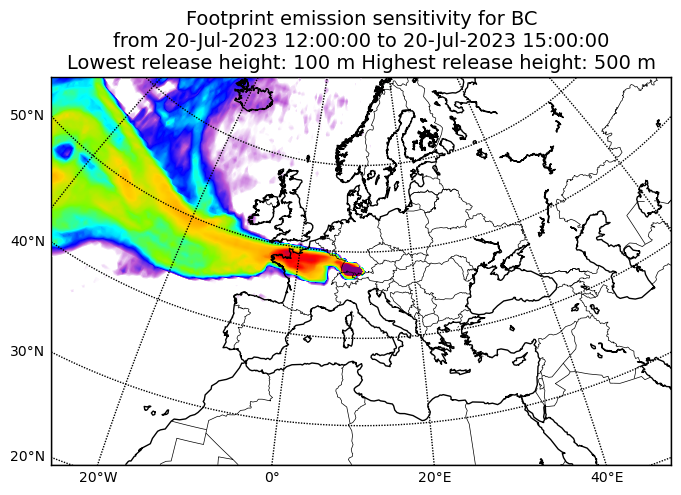

In [10]:
######## MAKE PLOT ########
def plot(dat,datE,xx,yy,lons,lats,zpoint1,zpoint2,var,area='GLOBAL'):
    ax = fig.add_subplot(111)
    ax.set_title('Footprint emission sensitivity for BC'+'\nfrom '+ dat.strftime("%d-%b-%Y %H:%M:%S")+' to '+datE.strftime("%d-%b-%Y %H:%M:%S")+'\nLowest release height: '+str(int(zpoint1))+' m Highest release height: '+str(int(zpoint2))+' m',fontsize=14)
    
    if area == 'GLOBAL':
        m = Basemap(projection='robin',lon_0=0,resolution='l')

    elif area == 'REGIONAL':
        m = Basemap(width=8000000,height=5000000,resolution='l',projection='stere',lat_ts=60.,lat_0=yy,lon_0=xx)

    elif area == 'POLAR':
        h = 10000.
        m = Basemap(projection='nsper',lon_0=xx,lat_0=90.,satellite_height=h*1000.,resolution='l')

    else:
        print("Error")
        sys.exit()

    lon, lat = np.meshgrid(lons, lats)
    xi, yi = m(lon, lat)
    
    levs = np.arange(-2,6.01,0.01)
    clevs = 2**levs
    boundlevs = [str(('%.2f' % v).rstrip('0').rstrip('.')) if v <=1 else str(int(round(v))) for v in clevs]
    
    m.drawcoastlines()
    if area == 'GLOBAL' or area == 'POLAR':
        m.drawparallels(np.arange(-90.,91.,30.), labels=[1,0,0,0], fontsize=10)
        m.drawmeridians(np.arange(-180.,181.,60.), labels=[0,0,0,1], fontsize=10)
    elif area == 'REGIONAL':
        m.drawparallels(np.arange(-90.,91.,10.), labels=[1,0,0,0], fontsize=10)
        m.drawmeridians(np.arange(-180.,181.,20.), labels=[0,0,0,1], fontsize=10)
    m.drawmapboundary()
    m.drawcountries()
    
    colors = ["purple", "red", "orange", "gold", "lawngreen", "cyan", "blue", "mediumorchid", "white"]
    cmap = LinearSegmentedColormap.from_list("cb_friendly", colors[::-1], N=900)
    norm = cm.colors.BoundaryNorm(boundaries=clevs,ncolors=cmap.N)
    
    cs = m.contourf(xi,yi,var[:,:],clevs,cmap=cmap,extend='both', norm=norm) 
    cbar = m.colorbar(cs,ticks=clevs[::100], location='bottom', pad="12%")
    cbar.set_label('seconds',fontsize=15)
    cbar.ax.set_xticklabels(boundlevs[::100])
    
    aa1,bb1= m(xx, yy)
    m.plot(aa1, bb1, marker='*', markersize=10, markeredgecolor='k',markeredgewidth=0.8,markerfacecolor='m',linestyle='')

# PLOT IT        
fig = plt.figure(figsize=(8,7.5))
plot(dat,datE,xx[0],yy[0],lons,lats,zz1[0],zz2[0],foot,area=PROJ)
fig.show()